In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time, os, sys, gc

import svgutils.transform as sg 

import scipy
from scipy.interpolate import RegularGridInterpolator

import h5py 

import class_energy as energy

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

## Functions for plotting, IO and time propagation

First: a function that allows quick plotting of wavefunctions

In [2]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

In [3]:
def get_tx_ty(sum, diff):
    '''  
    Return tx and ty tunneling rates
    '''
    tx = 0.5*(sum+diff)
    ty = 0.5*(sum-diff)
    return tx, ty

## Define Calculation Parameters

In [4]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-9}

x = (2*np.pi/params["n"])*np.arange(params["n"])

Mx = params["Mx"]
My = params["My"]

n = params["n"]

tx = params["tx"]
ty = params["ty"]

B = params["B"]
V_0 = params["V_0"]

scale = B 


''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

Scan specifications

In [198]:
sum_tx_ty = 200
diff_tx_ty = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])
V_0_arr = np.arange(0,355,5) #np.array([0,25,50,75,100,125,150,175,200,225,250])

diff_tx_ty_fdh = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125])
diff_tx_ty_fdv = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125])

print('V_0 =', V_0_arr, '\n')
for i in diff_tx_ty:
    print('tx,ty =', get_tx_ty(sum_tx_ty,i))

V_0 = [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350] 

tx,ty = (0.0, 200.0)
tx,ty = (12.5, 187.5)
tx,ty = (25.0, 175.0)
tx,ty = (37.5, 162.5)
tx,ty = (50.0, 150.0)
tx,ty = (62.5, 137.5)
tx,ty = (75.0, 125.0)
tx,ty = (87.5, 112.5)
tx,ty = (99.5, 100.5)
tx,ty = (100.5, 99.5)
tx,ty = (112.5, 87.5)
tx,ty = (125.0, 75.0)
tx,ty = (137.5, 62.5)
tx,ty = (150.0, 50.0)
tx,ty = (162.5, 37.5)
tx,ty = (175.0, 25.0)
tx,ty = (187.5, 12.5)
tx,ty = (200.0, 0.0)


In [6]:
def get_psi_properties(file_path, check_size, check_sym):
    h5_io_object = h_in.io_hdf5()
    file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

    V_0_arr = np.zeros(len(file_list), dtype=complex)

    E_arr = np.zeros(len(file_list), dtype=complex)
    B_arr = np.zeros(len(file_list), dtype=complex)
    V_arr = np.zeros(len(file_list), dtype=complex)
    Tx_arr = np.zeros(len(file_list), dtype=complex)
    Ty_arr = np.zeros(len(file_list), dtype=complex)

    i = 0
    for file in file_list:
        psi, params = h5_io_object.get_psi(file_path+file)

        energy_object = energy.energy(params=params)

        E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
        Tx, Ty = energy_object.deriv_dE_dt(psi)

        E_arr[i] = E[0]
        B_arr[i] = E[2]
        V_arr[i] = E[3]
        Ty_arr[i] = Ty
        Tx_arr[i] = Tx

        V_0_arr[i] = params['V_0']

        i += 1

    index_sort = np.argsort(V_0_arr)

    V_0_arr = V_0_arr[index_sort]

    E_arr = E_arr[index_sort]
    B_arr = B_arr[index_sort]
    V_arr = V_arr[index_sort]
    Tx_arr = Tx_arr[index_sort]
    Ty_arr = Ty_arr[index_sort]

    return V_0_arr, E_arr, B_arr, V_arr, Tx_arr, Ty_arr

In [37]:
def get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path):
    V_0_order = []
    E_order = []
    B_order = []
    V_order = []
    Tx_order = []
    Ty_order = []
    for j in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

        check_sym  = 'tx_'+str(tx)+'_ty_'+str(ty)
        V_0_list, E_arr, B_arr, V_arr, Tx_arr, Ty_arr = get_psi_properties(file_path, check_size, check_sym)

        V_0_order.append(V_0_list)
        E_order.append(E_arr)
        B_order.append(B_arr)
        V_order.append(V_arr)
        Tx_order.append(Tx_arr)
        Ty_order.append(Ty_arr)

    print(len(V_0_order))
    #print(V_0_order)
    print(V_0_order[0])
    
    V_0_order = np.array([x for x in V_0_order])
    E_order = np.array([x for x in E_order])
    B_order = np.array([x for x in B_order])
    V_order = np.array([x for x in V_order])
    Tx_order = np.array([x for x in Tx_order])
    Ty_order = np.array([x for x in Ty_order])

    return V_0_order, E_order, Tx_order, Ty_order

In [178]:
''' 
FO Results
'''
Mx = 8
My = 8
check_size = '_B_1.0_Mx_'+str(Mx)+'_My_'+str(My)
file_path = 'results/phase_diagram/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr, E_arr_fo, Tx_fo, Ty_fo = get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path)

''' 
FDh Results
'''
Mx = 16
My = 4
check_size = '_B_1.0_Mx_'+str(Mx)+'_My_'+str(My)
file_path = 'results/phase_diagram/fdh/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdh, E_arr_fdh, Tx_fdh, Ty_fdh = get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path)

''' 
FDv Results
'''
Mx = 4
My = 32
check_size = '_B_1.0_Mx_'+str(Mx)+'_My_'+str(My)
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDh calculations - please wait!')
V_0_arr_fdv, E_arr_fdv, Tx_fdv, Ty_fdv = get_e_arr(check_size, sum_tx_ty, diff_tx_ty_fdh, file_path)


''' 
SP Results
'''
Mx = 8
My = 8
check_size = 'Mx_'+str(Mx)+'_My_'+str(My)
file_path = 'results/phase_diagram/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr, E_arr_sp, Tx_sp, Ty_sp = get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path)

Reading results from FO calculations - please wait!
18
[  0.+0.j   5.+0.j  10.+0.j  15.+0.j  20.+0.j  25.+0.j  30.+0.j  35.+0.j
  40.+0.j  45.+0.j  50.+0.j  55.+0.j  60.+0.j  65.+0.j  70.+0.j  75.+0.j
  80.+0.j  85.+0.j  90.+0.j  95.+0.j 100.+0.j 105.+0.j 110.+0.j 115.+0.j
 120.+0.j 125.+0.j 130.+0.j 135.+0.j 140.+0.j 145.+0.j 150.+0.j 155.+0.j
 160.+0.j 165.+0.j 170.+0.j 175.+0.j 180.+0.j 185.+0.j 190.+0.j 195.+0.j
 200.+0.j 205.+0.j 210.+0.j 215.+0.j 220.+0.j 225.+0.j 230.+0.j 235.+0.j
 240.+0.j 245.+0.j 250.+0.j 255.+0.j 260.+0.j 265.+0.j 270.+0.j 275.+0.j
 280.+0.j 285.+0.j 290.+0.j 295.+0.j 300.+0.j 305.+0.j 310.+0.j 315.+0.j
 320.+0.j 325.+0.j 330.+0.j 335.+0.j 340.+0.j 345.+0.j 350.+0.j]
Reading results from FDh calculations - please wait!


KeyboardInterrupt: 

In [374]:
from scipy import sparse

def dy_dx_stencil_3(x):
    dx = x[1]-x[0]
    dy_dx = sparse.diags([-1/2, 0, 1/2], [-1, 0, 1], shape=(len(x), len(x))) / dx
    return dy_dx.toarray()
    
def laplace_stencil_3(x):
    dx = x[1]-x[0]
    laplace = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(len(x), len(x))) / dx**2
    return laplace.toarray()

def find_jumps(E_arr, diff_tx_ty, V0_arr, jump_sign):
    E_arr = E_arr.copy()
    E_arr_n = np.zeros(E_arr.shape, dtype=complex)
    for i in range(len(diff_tx_ty)):
        E_V0 = E_arr[i].copy()
        E_V0_diff_nn = np.diff(E_V0)
        diff_avg = np.average(E_V0_diff_nn)
        #print(E_V0)
        #print(E_V0_diff_nn)
        #print(diff_avg)

        # create convolution kernel for calculating
        # the smoothed second order derivative
        smooth_width = 59
        x1 = np.linspace(-3,3,smooth_width)
        norm = np.sum(np.exp(-x1**2)) * (x1[1]-x1[0]) # ad hoc normalization
        y1 = (4*x1**2 - 2) * np.exp(-x1**2) / smooth_width *8#norm*(x1[1]-x1[0])

        # calculate second order deriv.
        y_conv = np.convolve(E_V0, y1, mode="same")

        dy_dx = dy_dx_stencil_3(V0_arr)
        laplace = laplace_stencil_3(V0_arr)

        E_first = dy_dx@E_V0
        E_sec = laplace@E_V0
        
        #plt.plot(y_conv)
        #plt.plot(E_sec)
        #plt.plot(E_first)
        #plt.plot(E_V0)

        if jump_sign == 'pos':
            jump_indices = np.where(np.diff(E_first)>1)[0][1:] #E_first[:-1] - 0.5 > E_first[1:])[0][1:]+1 #E_V0[:-1] - 1 > E_V0[1:])[0]
            E_V0[jump_indices[0]:] = np.zeros((len(V0_arr))-jump_indices[0])
            E_arr_n[i] = E_V0
        elif jump_sign == 'neg':
            jump_indices = np.where(np.diff(E_first)<-0.6)[0][1:]

            E_V0[:jump_indices[0]+1] = np.zeros(jump_indices[0]+1)
            E_arr_n[i] = E_V0
        #print(jump_indices)
        
        
    return E_arr_n

def clean_phase(E_arr, Tx, Ty, phase):
    E_arr_n = np.zeros(E_arr.shape, dtype=complex)
    Tx_n = np.zeros(E_arr.shape, dtype=complex)
    Ty_n = np.zeros(E_arr.shape, dtype=complex)

    for i in range(E_arr.shape[0]):
        for j in range(E_arr.shape[1]):
            if phase == 'fo':
                if Tx[i,j] > 0.1 and Ty[i,j] > 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'fdv':
                if Ty[i,j] > 0.5 and Tx[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'fdh':
                if Tx[i,j] > 0.5 and Ty[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j]
            elif phase == 'sp':
                if Ty[i,j] < 0.1 and Tx[i,j] < 0.1:
                    E_arr_n[i,j] = E_arr[i,j]
                    Tx_n[i,j] = Tx[i,j]
                    Ty_n[i,j] = Ty[i,j] 
    return E_arr_n, Tx_n, Ty_n
    
def outer_fo_lines(E_arr, diff_tx_ty, V0_arr):
    E_arr_n = E_arr.copy()
    E_arr_n[0] = np.zeros(len(V0_arr), dtype=complex)
    E_arr_n[-1] = np.zeros(len(V0_arr), dtype=complex)
    return E_arr_n



E_arr_fo_new = find_jumps(E_arr_fo, diff_tx_ty, V_0_arr, 'pos')
E_arr_fo_new = outer_fo_lines(E_arr_fo_new, diff_tx_ty, V_0_arr)

E_arr_fdv_new = find_jumps(E_arr_fdv, diff_tx_ty, V_0_arr, 'pos')
E_arr_fdh_new = find_jumps(E_arr_fdh, diff_tx_ty, V_0_arr, 'pos')
E_arr_sp_new = find_jumps(E_arr_sp, diff_tx_ty, V_0_arr, 'neg')

E_fo_new, Tx_fo_new, Ty_fo_new = clean_phase(E_arr_fo, np.abs(Tx_fo), np.abs(Ty_fo), 'fo')
E_fdv_new, Tx_fo_new, Ty_fo_new = clean_phase(E_arr_fdv, np.abs(Tx_fdv), np.abs(Ty_fdv), 'fdv')
E_fdh_new, Tx_fo_new, Ty_fo_new = clean_phase(E_arr_fdh, np.abs(Tx_fdh), np.abs(Ty_fdh), 'fdh')
E_sp_new, Tx_fo_new, Ty_fo_new = clean_phase(E_arr_sp, np.abs(Tx_sp), np.abs(Ty_sp), 'sp')

(18, 71)


(18, 71)

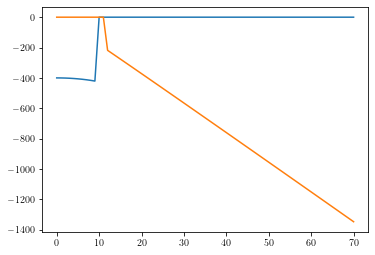

In [382]:
print(E_fo_new.shape)
plt.plot(E_fo_new[2])
plt.plot(E_sp_new[10])
#plt.plot(E_arr_fo_new[1].real)
#plt.plot(E_arr_fo[1].real)
#plt.plot(E_arr_fdv_new[2].real)
#plt.plot(E_arr_fdv[2].real)
#plt.plot(E_arr_sp_new[0].real)
#plt.plot(E_arr_sp[0].real)
#plt.plot(E_arr_fo[8].real)
#plt.plot(E_arr_fdv[1].real) #, marker='x')
E_arr_fdh.shape

In [114]:
''' 
For now: cheat with FDv calculations
'''
E_arr_fdv = np.flip(E_arr_fdh.copy(), axis=0)

Tx_fdv = np.flip(Ty_fdh.copy(), axis=0)
Ty_fdv = np.flip(Tx_fdh.copy(), axis=0)

In [383]:
def get_gs_props(E_arr_fo, E_arr_fdv, E_arr_fdh, E_arr_sp, Tx_fo, Ty_fo, Tx_fdv, Ty_fdv, Tx_fdh, Ty_fdh, Tx_sp, Ty_sp):
    state_no = 0

    E_gs = np.zeros(E_arr_fo.shape, dtype=complex)
    Tx_order = np.zeros(E_arr_fo.shape, dtype=complex)
    Ty_order = np.zeros(E_arr_fo.shape, dtype=complex)

    for i in range(len(diff_tx_ty)):
        for j in range(len(V_0_arr)):
            E_fo  = E_arr_fo[i,j].real
            E_fdv = E_arr_fdv[i,j].real
            E_fdh = E_arr_fdh[i,j].real
            E_sp  = E_arr_sp[i,j].real

            Tx_fo_s  = Tx_fo[i,j]
            Tx_fdv_s = Tx_fdv[i,j]
            Tx_fdh_s = Tx_fdh[i,j]
            Tx_sp_s  = Tx_sp[i,j]

            Ty_fo_s  = Ty_fo[i,j]
            Ty_fdv_s = Ty_fdv[i,j]
            Ty_fdh_s = Ty_fdh[i,j]
            Ty_sp_s  = Ty_sp[i,j]

            E_arr  = np.array([E_fo,E_fdv,E_fdh,E_sp])
            Tx_arr = np.array([Tx_fo_s,Tx_fdv_s,Tx_fdh_s,Tx_sp_s])
            Ty_arr = np.array([Ty_fo_s,Ty_fdv_s,Ty_fdh_s,Ty_sp_s])

            E_index = np.argsort(E_arr)

            E_arr  = E_arr[E_index]
            Tx_arr = Tx_arr[E_index]
            Ty_arr = Ty_arr[E_index]
        
            E_gs[i,j] = E_arr[state_no]
            Tx_order[i,j] = Tx_arr[state_no]
            Ty_order[i,j] = Ty_arr[state_no]
    return E_gs, Tx_order, Ty_order

E_gs_new, Tx_order_new, Ty_order_new = get_gs_props(E_fo_new, E_fdv_new, E_fdh_new, E_sp_new, Tx_fo, Ty_fo, Tx_fdv, Ty_fdv, Tx_fdh, Ty_fdh, Tx_sp, Ty_sp)

In [11]:
def interpolate_data(x, y, data):
    f = scipy.interpolate.RegularGridInterpolator((x.real, y.real), data.real)
    
    Xnew = np.linspace(x[0].real, x[-1].real, 300)
    Ynew = np.linspace(y[0].real, y[-1].real, 300)
    Xnew, Ynew = np.meshgrid(Xnew, Ynew, indexing='ij')

    data_new = f((Xnew,Ynew), method='linear').T
    return Xnew, Ynew, data_new

In [12]:
def find_transition(V_0, Tx, Ty):
    V_trans1 = 0
    V_trans2 = 0

    i1 = 0
    i2 = 0
    for i in range(len(V_0)):
        delta_T = np.abs(Tx[i]-Ty[i])
        sum_T = np.abs(Tx[i]+Ty[i])
        if delta_T > 1 and sum_T < 2 and i1 == 0:
            V_trans1 = (V_0[i-1]+V_0[i])/2
            i1 += 1
        elif sum_T < 0.2 and i2 == 0:
            V_trans2 = (V_0[i-1]+V_0[i])/2
            i2 += 1
    return V_trans1, V_trans2

def loop_over_sym(V_0_arr, Tx_order, Ty_order):
    V1 = np.zeros(len(V_0_arr))
    V2 = np.zeros(len(V_0_arr))
    for i in range(len(V_0_arr)):
        V_0 = V_0_arr[i]
        Tx = Tx_order[i]
        Ty = Ty_order[i]
        V1[i], V2[i] = find_transition(V_0, Tx, Ty)
    return V1, V2

def fit_transition(diff_tx_ty, sum_tx_ty, Vtrans):
    x = diff_tx_ty/sum_tx_ty
    y = Vtrans
    a, b = np.polyfit(x, y, 1)
    return a, b

def get_trans_line(x0, x1, sum_tx_ty, a, b):
    x_arr = np.linspace(x0,x1,100)
    y_arr = a*(x_arr/sum_tx_ty) + b
    return y_arr, x_arr
    
V1, V2 = loop_over_sym(V_0_arr.real, Tx_order, Ty_order)

a1, b1 = fit_transition(diff_tx_ty[3:int(len(V1)/2)-1], sum_tx_ty, V1[3:int(len(V1)/2)-1].real)
x1, y1 = get_trans_line(-200, 0, sum_tx_ty, a1, b1)
print('a,b =', a1,b1)

a2, b2 = fit_transition(diff_tx_ty[int(len(V1)/2)+1:len(V1)-2], sum_tx_ty, V1[int(len(V1)/2)+1:len(V1)-2].real)
x2, y2 = get_trans_line(0, 200, sum_tx_ty, a2, b2)
print('a,b =', a2,b2)

a3, b3 = fit_transition(diff_tx_ty[3:int(len(V2)/2)-1], sum_tx_ty, V2[3:int(len(V2)/2)-1].real)
x3, y3 = get_trans_line(-200, 0, sum_tx_ty, a3, b3)
print('a,b =', a3,b3)

a4, b4 = fit_transition(diff_tx_ty[int(len(V2)/2)+1:len(V2)-2], sum_tx_ty, V2[int(len(V2)/2)+1:len(V2)-2].real)
x4, y4 = get_trans_line(0, 200, sum_tx_ty, a4, b4)
print('a,b =', a4,b4)

x5 = np.linspace(x1[-1],x4[0],100)
y5 = np.zeros(len(x5))

a,b = 103.99999999999999 111.49999999999997
a,b = -105.14285714285717 111.83333333333333
a,b = -180.00000000000006 175.99999999999994
a,b = 175.99999999999997 177.16666666666669


In [115]:
X_intp, Y_intp, E_fo_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, E_arr_fo.real)
X_intp_fdv, Y_intp_fdv, E_fdv_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, E_arr_fdv.real)
X_intp_fdh, Y_intp_fdh, E_fdh_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, E_arr_fdh.real)
X_intp_sp, Y_intp_sp, E_sp_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, E_arr_sp.real)

X_intp, Y_intp, Tx_fo_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, Tx_fo.real)
X_intp, Y_intp, Tx_fdv_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, Tx_fdv.real)
X_intp, Y_intp, Tx_fdh_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, Tx_fdh.real)
X_intp, Y_intp, Tx_sp_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, Tx_sp.real)

X_intp, Y_intp, Ty_fo_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, Ty_fo.real)
X_intp, Y_intp, Ty_fdv_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, Ty_fdv.real)
X_intp, Y_intp, Ty_fdh_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, Ty_fdh.real)
X_intp, Y_intp, Ty_sp_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, Ty_sp.real)

E_gs_int = np.zeros(E_fo_interp.shape)
Tx_gs_int = np.zeros(E_fo_interp.shape)
Ty_gs_int = np.zeros(E_fo_interp.shape)
for i in range(len(X_intp)):
    for j in range(len(X_intp)):
        E_arr = np.array([E_fo_interp[i,j],E_fdv_interp[i,j],E_fdh_interp[i,j],E_sp_interp[i,j]])
        Tx_arr = np.array([Tx_fo_interp[i,j],Tx_fdv_interp[i,j],Tx_fdh_interp[i,j],Tx_sp_interp[i,j]])
        Ty_arr = np.array([Ty_fo_interp[i,j],Ty_fdv_interp[i,j],Ty_fdh_interp[i,j],Ty_sp_interp[i,j]])
        
        E_index = np.argsort(E_arr)
        
        E_arr = E_arr[E_index]
        Tx_arr = Tx_arr[E_index]
        Ty_arr = Ty_arr[E_index]
        
        E_gs_int[i,j] = E_arr[0].real
        Tx_gs_int[i,j] = Tx_arr[0].real
        Ty_gs_int[i,j] = Ty_arr[0].real

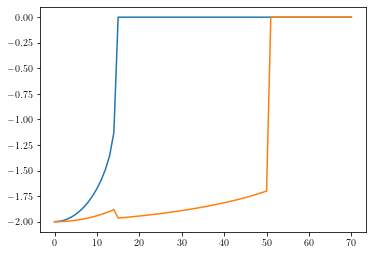

In [343]:
plt.plot(Tx_fo[3])
plt.plot(Ty_fo[3])

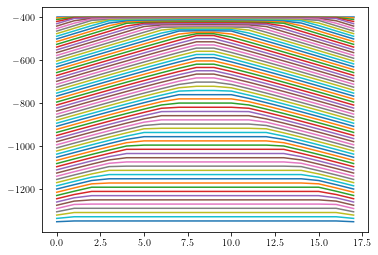

In [395]:
#plt.plot(E_arr_fo_new[0])
#plt.plot(E_arr_fdv_new[0])
#plt.plot(E_arr_fdh_new[0])
plt.plot(E_gs_new)

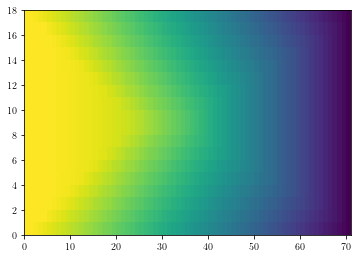

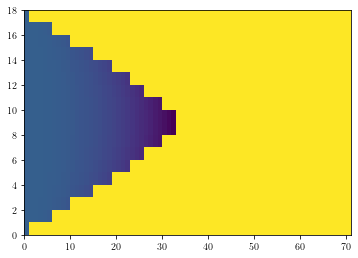

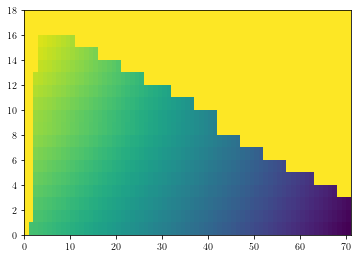

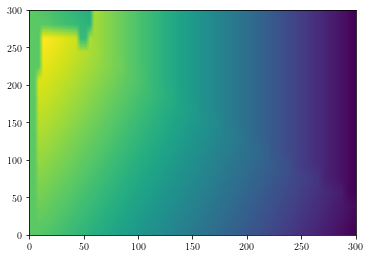

(18, 71)


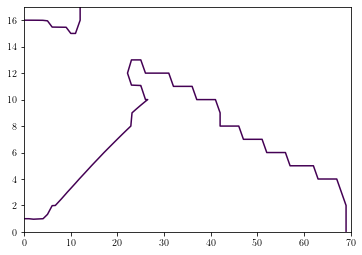

In [394]:
plt.pcolormesh(E_gs_new.real); plt.show()
plt.pcolormesh(E_fo_new.real); plt.show()
plt.pcolormesh(E_fdv_new.real); plt.show()
plt.pcolormesh(E_fdv_interp.T); plt.show()
fig, axs = plt.subplots()
print(E_arr_fdv.shape)
axs.contour(E_arr_fo_new - E_arr_fdv_new, levels = [0])
#axs.contour(E_arr_fo - E_arr_fdv, levels = [0])
plt.show()
#axs.contour(E_fo_interp.T - E_fdh_interp.T, levels = [0])
#axs.contour(E_fdv_interp.T - E_sp_interp.T, levels = [0], linewidth=2)
#axs.contour(E_fdh_interp.T - E_sp_interp.T, levels = [0])

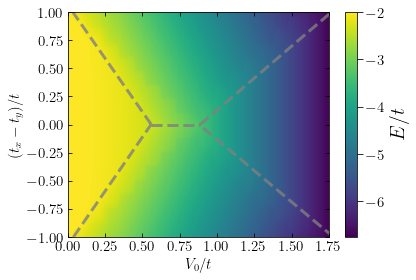

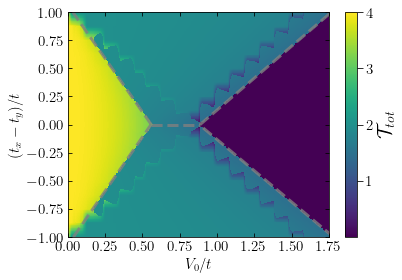

In [84]:
t = 200
X, Y = np.meshgrid(V_0_arr[0].real, diff_tx_ty.real)

X_intp1, Y_intp1, E_gs_interp = interpolate_data(diff_tx_ty, V_0_arr[0].real, E_gs.real)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

#pc = plt.pcolormesh(X,Y,E_gs.real, linewidth=0.)
pc = ax.pcolormesh(Y_intp/t, X_intp/t, E_gs_int.T/t, antialiased=False)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6, labelsize=font_size)
cbar.set_label(label=r'$E/t$', size=20)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

plt.plot(x1/t,y1/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x2/t,y2/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x3/t,y3/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x4/t,y4/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x5/t,y5/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)

#plt.xticks(np.arange(len(V_0_arr[0]))[0::10]+0.5, V_0_arr[0][0::10].real)
#plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)

plt.xlim(0,V_0_arr[0][-1].real/t)
plt.ylim(-1,1)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(t_x-t_y)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/phase_diagram/energies_B_1.0.svg')
plt.show()


#X_intp, Y_intp, order_p_interp = interpolate_data(diff_tx_ty, V_0_arr[0], order_p.real)

fig = plt.figure()
pc = plt.pcolormesh(Y_intp/t, X_intp/t,np.abs(Tx_gs_int+Ty_gs_int).T)
#pc = plt.contourf(Y_intp, X_intp, order_p_interp.T)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6, labelsize=font_size)
cbar.set_label(label=r'$\mathcal{T}_{tot}$', size=20)

plt.plot(x1/t,y1/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x2/t,y2/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x3/t,y3/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x4/t,y4/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x5/t,y5/t, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
 
#plt.xticks(np.arange(len(V_0_arr[0]))[0::10]+0.5, V_0_arr[0][0::10].real)
#plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)

plt.xlim(0,V_0_arr[0][-1].real/t)
plt.ylim(-1,1)

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(t_x-t_y)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.show()

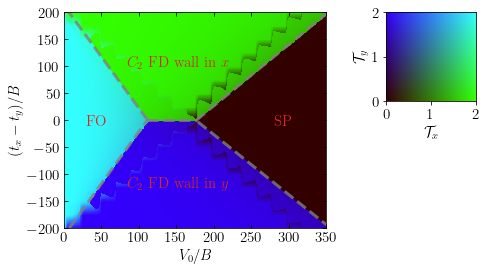

In [15]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 15

fig, ax = plt.subplots(figsize=[53 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
#ax.set_aspect("equal")

x = np.linspace(diff_tx_ty[0].real, diff_tx_ty[-1].real, 300) #diff_tx_ty.real 
y = np.linspace(V_0_arr[0][0].real, V_0_arr[0][-1].real, 300) #V_0_arr[0].real 
p1 = Tx_gs_int.T #Tx_order.real
p2 = Ty_gs_int.T #Ty_order.real

# create a very simple colormap, 
#  mapping parameter 1 to the red channel and 
#          parameter 2 to the blue channel
green_frac = 0.2
cmap = lambda p1,p2 : (green_frac, np.abs(p1/2), np.abs(p2/2))

order_p_new = cmap(Tx_order.real, Ty_order.real)
#print(order_p[0])
#plt.pcolormesh(order_p[0])

#xpoints = [0,x1[0],x1[-1],x2[-1],0] #[0.3,0.6,.5,.4]
#ypoints = [-200,y1[0],y1[-1],y2[-1],200]
#ax.add_patch(matplotlib.patches.Polygon(xy=list(zip(xpoints,ypoints)), fill=True, color=cmap(p1[9,2],p2[9,2]), alpha=1))

#xpoints = [x1[0],x1[-1],x3[-1],x3[0]] #[0.3,0.6,.5,.4]
#ypoints = [y1[0],y1[-1],y3[-1],y3[0]]
#ax.add_patch(matplotlib.patches.Polygon(xy=list(zip(xpoints,ypoints)), fill=True, color=cmap(p1[3,35],p2[3,35]), alpha=1))

#xpoints = [x2[-1],x2[0],x4[0],x4[-1]] #[0.3,0.6,.5,.4]
#ypoints = [y2[-1],y2[0],y4[0],y4[-1]]
#ax.add_patch(matplotlib.patches.Polygon(xy=list(zip(xpoints,ypoints)), fill=True, color=cmap(p1[13,35],p2[13,35]), alpha=1))

#xpoints = [x3[0],x4[0],x4[-1]] #[0.3,0.6,.5,.4]
#ypoints = [y3[0],y4[0],y4[-1]]
#ax.add_patch(matplotlib.patches.Polygon(xy=list(zip(xpoints,ypoints)), fill=True, color=cmap(p1[9,60],p2[9,60]), alpha=1))

for i in range(len(x)):
    for j in range(len(y)):
        circle = matplotlib.patches.Rectangle((y[j], x[i]), 2, 2, color=cmap(p1[i,j],p2[i,j]))
        ax.add_artist(circle)
        
plt.plot(x1,y1, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x2,y2, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x3,y3, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x4,y4, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)
plt.plot(x5,y5, linestyle='dashed', color='grey', linewidth=3, alpha=0.8)

ax.annotate(r'FO', xy=(150, 130), xytext=(30, -10), fontsize=font_size, color='tab:red')
ax.annotate(r'$C_2$ FD wall in $x$', xy=(150, 130), xytext=(85, 100), fontsize=font_size, color='tab:red')
ax.annotate(r'$C_2$ FD wall in $y$', xy=(150, 130), xytext=(85, -125), fontsize=font_size, color='tab:red')
ax.annotate(r'SP', xy=(150, 130), xytext=(280, -10), fontsize=font_size, color='tab:red')

plt.xlim(0,350)
plt.ylim(-200,200)

plt.xlabel(r'$V_0/B$', fontsize=font_size)
plt.ylabel(r'$(t_x-t_y)/B$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.subplots_adjust(left=0.1, right=0.65, top=0.85)
cax = fig.add_axes([0.72,0.55,0.3,0.3])
cp1 = np.linspace(0, 1, 100)
cp2 = np.linspace(0, 1, 100)
Cp1, Cp2 = np.meshgrid(cp1,cp2)
C0 = green_frac*np.ones_like(Cp2)
# make RGB image, p1 to red channel, p2 to blue channel
Legend = np.dstack((C0,Cp1,Cp2))
# parameters range between 0 and 1
cax.imshow(Legend, origin="lower", extent=[0,2,0,2])
cax.set_xticks([0,1,2], [r'0',r'1',r'2'], fontsize=font_size)
cax.set_yticks([0,1,2], [r'0',r'1',r'2'], fontsize=font_size)
cax.set_xlabel(r'$\mathcal{T}_x$', fontsize=font_size)
cax.set_ylabel(r'$\mathcal{T}_y$', fontsize=font_size)
#cax.set_title("2D cmap legend", fontsize=10)

plt.savefig('results/phase_diagram/order_parameters_B_1.0.svg')
plt.show()

In [488]:
import svgutils.transform as sg 

fig = sg.SVGFigure("16cm", "16cm")

fig1 = sg.fromfile('results/phase_diagram/energies_B_1.0.svg')
fig2 = sg.fromfile('results/phase_diagram/order_parameters_B_1.0.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()

plot2.moveto(5,300)

txt1 = sg.TextElement(0,20, r"a)", size=20)
txt2 = sg.TextElement(0,330, r"b)", size=20) 

fig.append([plot1,plot2])
fig.append([txt1,txt2])

fig.save('results/phase_diagram/phase_diagram_B_1.0.svg')

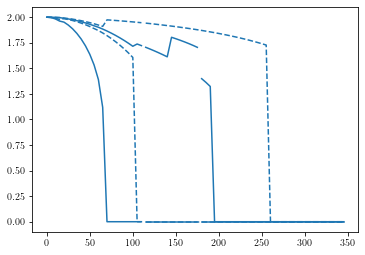

In [42]:
V = V_0_arr.real[0]

slice_index = 3
plt.plot(V[0:23], np.abs(Tx_order[slice_index])[0:23], linestyle='solid', color='tab:blue')
plt.plot(V[0:23], np.abs(Ty_order[slice_index])[0:23], linestyle='dashed', color='tab:blue')
plt.plot(V[23:36], np.abs(Tx_order[slice_index])[23:36], linestyle='solid', color='tab:blue')
plt.plot(V[23:len(Tx_order[slice_index])-1], np.abs(Ty_order[slice_index])[23:len(Tx_order[slice_index])-1], linestyle='dashed', color='tab:blue')
plt.plot(V[36:len(Tx_order[slice_index])-1], np.abs(Tx_order[slice_index])[36:len(Tx_order[slice_index])-1], linestyle='solid', color='tab:blue')

slice_index = 10
plt.plot(V[0:23], np.abs(Tx_order[slice_index])[0:23], linestyle='solid', color='tab:blue')
plt.plot(V[0:23], np.abs(Ty_order[slice_index])[0:23], linestyle='dashed', color='tab:blue')
plt.plot(V[23:36], np.abs(Tx_order[slice_index])[23:36], linestyle='solid', color='tab:blue')
plt.plot(V[23:len(Tx_order[slice_index])-1], np.abs(Ty_order[slice_index])[23:len(Tx_order[slice_index])-1], linestyle='dashed', color='tab:blue')
plt.plot(V[36:len(Tx_order[slice_index])-1], np.abs(Tx_order[slice_index])[36:len(Tx_order[slice_index])-1], linestyle='solid', color='tab:blue')

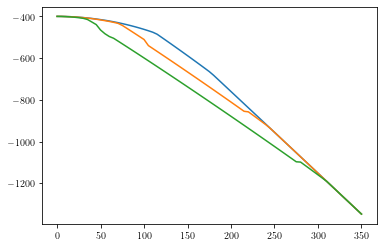

In [424]:
plt.plot(V_0_arr[0].real, E_gs[8].real)
plt.plot(V_0_arr[0].real, E_gs[5].real)
plt.plot(V_0_arr[0].real, E_gs[2].real)

-175


/nfs/scistore12/lemesgrp/fkluiben/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


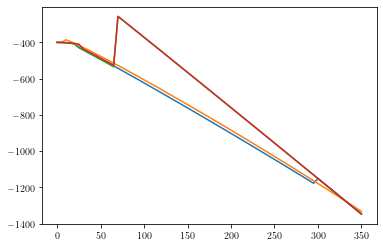

In [415]:
symmetry_index = 1

print(diff_tx_ty[symmetry_index])

%matplotlib inline
plt.plot(V_0_arr[0], E_arr_fo[symmetry_index])
plt.plot(V_0_arr[0], E_arr_fdv[symmetry_index])
plt.plot(V_0_arr[0], E_arr_fdh[symmetry_index])
plt.plot(V_0_arr[0], E_arr_sp[symmetry_index])

#plt.plot(V_0_arr, E_gs.T[0])

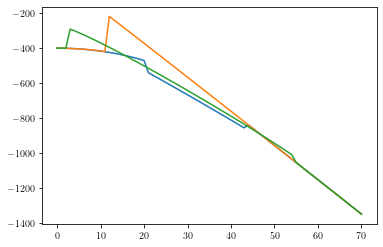

In [68]:
%matplotlib inline

plt.plot(E_arr_fo[5])
plt.plot(E_arr_sp[7])
#plt.plot(E_arr_fdv[1])
#plt.plot(E_arr_fdv[2])
#plt.plot(E_arr_fdv[3])
#plt.plot(E_arr_fdv[4])
#plt.plot(E_arr_fdv[5])
#plt.plot(E_arr_fdv[6])
#plt.plot(E_arr_fdv[7])
#plt.plot(E_arr_fdv[8])
plt.plot(E_arr_fdv[5])
#plt.plot(E_arr_fdv[10])
#plt.plot(E_arr_fdv[11])
#plt.plot(E_arr_fdv[12])
#plt.plot(E_arr_fdv[13])



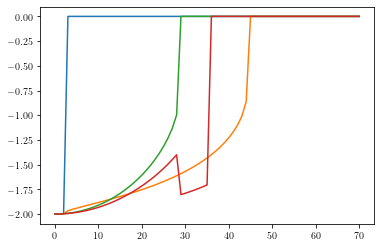

In [65]:
plt.plot(Tx_fdv[7])
plt.plot(Ty_fdv[7])
plt.plot(Tx_fo[7])
plt.plot(Ty_fo[7])